# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
import string
from collections import Counter
import datetime as dt
import pickle as pkl
import os
import json
import matplotlib.pyplot as plt
import re
#import jsonlines
import numpy as np
from collections import defaultdict
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
    from google.colab import drive
    drive.mount('/content/gdrive')
    path = 'gdrive/My Drive/'
else:
    current_device = 'cpu'
    path = './'


## I. N-Gram Language Modeling

#### Utilities

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [2]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [0]:
wiki_datasets, vocab = load_wikitext()

delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(wiki_datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, wiki_datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, wiki_datasets['valid'])))

Vocab size: 33175
Baseline (Additive smoothing, n=2, delta=0.0005)) Train Perplexity: 90.228
Baseline (Additive smoothing, n=2, delta=0.0005)) Valid Perplexity: 525.825
Baseline (Additive smoothing, n=3, delta=0.0005)) Train Perplexity: 26.768
Baseline (Additive smoothing, n=3, delta=0.0005)) Valid Perplexity: 2577.128
Baseline (Additive smoothing, n=4, delta=0.0005)) Train Perplexity: 19.947
Baseline (Additive smoothing, n=4, delta=0.0005)) Valid Perplexity: 9570.901


### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    def __init__(self, n, lambdas, vsize, total_word_count):
        self.n = n
        self.lambdas = lambdas
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
        self.total_word_count = total_word_count
        
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(self.n-1, len(padded_sequence)):
                ngram = tuple(padded_sequence[i-self.n+1:i+1])
                for j in range(1, self.n):
                    prefix, word = ngram[:j], ngram[j]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1 
                    self.total[word] += 1
                    
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prob = self.lambdas[-1]/self.vsize
        word = ngram[-1]
        prob += (self.total[word] / self.total_word_count) * self.lambdas[-2]
        for nk in range(len(ngram) - 1):
            prefix = ngram[nk:-1]
            if self.total[prefix] > 1e-9:
                prob += ((self.count[prefix][word])/ (self.total[prefix])) * self.lambdas[nk]
            
        return prob

In [0]:
total_wc = len([t for ts in wiki_datasets['train'] for t in ts])
print(total_wc)

1924754


#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [0]:
found = False
while not(found):
    perplexs = []
    for n in [2, 3, 4]:
        #lambdas = [1/(n+1) for i in range(n+1)]

        # Uncomment to input in the following format #.##,#.##,#.##(...)
        # lam = input()
        # lambdas = [float(i) for i in lam.split(",")]

        # Random search using Dirichlet Distribution (Notice: lambdas add to 1)
        lambdas = np.ravel(np.random.dirichlet(np.ones(n),size=1))
        print('Lambdas add to:',sum(np.ravel(np.random.dirichlet(np.ones(n),size=1))))

        lm = NGramInterpolation(n=n, lambdas=lambdas, vsize=len(vocab)+1, total_word_count = total_wc)  # +1 is for <eos>
        lm.estimate(wiki_datasets['train'])

        print("lambdas = " + str(lambdas))
        print("Interpolation, n=%d | Train Perplexity: %.3f" % (n, perplexity(lm, wiki_datasets['train'])))
        print("Interpolation, n=%d | Valid Perplexity: %.3f" % (n, perplexity(lm, wiki_datasets['valid'])))
        perplexs.append(perplexity(lm, wiki_datasets['valid']))
        
        # If initial perplexity is not better than Additive Smoothing
        if (n == 2) and perplexs[n-2] > 525:
            break
        
        # If the next n-gram is not better than last one found
        if ( n > 2 ):
            if (perplexs[n-2] < perplexs[n-3]):
                if n == 4:
                    found = True
                    print("A good configuration has been found")
                continue
            else:
                break

Lambdas add to: 1.0
lambdas = [0.20953827 0.79046173]
Interpolation, n=2 | Train Perplexity: 262.011
Interpolation, n=2 | Valid Perplexity: 516.755
Lambdas add to: 0.9999999999999999
lambdas = [0.25564492 0.49439094 0.24996414]
Interpolation, n=3 | Train Perplexity: 18.841
Interpolation, n=3 | Valid Perplexity: 170.144
Lambdas add to: 1.0
lambdas = [0.13951532 0.01370735 0.57312293 0.27365439]
Interpolation, n=4 | Train Perplexity: 10.124
Interpolation, n=4 | Valid Perplexity: 158.523
A good configuration has been found


## II. Neural Language Modeling with a Recurrent Neural Network

## LSTM RNN Model 

In [2]:
print('Current device: {}'.format(current_device))
print('Current path: {}'.format(path))

Current device: cpu
Current path: ./


In [2]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def tokenize(document):
    tokens = tokenizer(document)
    tokens = [token.text.lower() for token in tokens if (token.text not in punctuations)]
    return tokens

In [3]:
def load_wikitext(fname):
    full_lines = []
    datasets_text = {
        'train': [],
        'valid': [],
        'test': [],
    }
    for jline in jsonlines.open(fname):
        for split in datasets_text.keys():
            for sentence in tqdm(jline[split]):
                datasets_text[split].append(tokenize(sentence))
        
    return datasets_text

In [0]:
# wikitext = load_wikitext('/Users/Antonio/Downloads/wikitext2-sentencized.json')

In [0]:
# pkl.dump(wikitext['train'], open('wiki_train_tokenized.p','wb'))
# pkl.dump(wikitext['valid'], open('wiki_val_tokenized.p', 'wb'))
# pkl.dump(wikitext['test'], open('wiki_test_tokenized.p','wb'))
# pkl.dump(wikitext, open('wiki_all_tokenized.p','wb'))

In [4]:
def load_wiki_data(path):
    wiki_train = pkl.load(open(path+'wiki_train_tokenized.p','rb'))
    wiki_val = pkl.load(open(path+'wiki_val_tokenized.p','rb'))
    wiki_test = pkl.load(open(path+'wiki_test_tokenized.p','rb'))
    wiki_all = pkl.load(open(path+'wiki_all_tokenized.p','rb'))
    
    return wiki_train, wiki_val, wiki_test, wiki_all

In [5]:
wiki_train, wiki_val, wiki_test, wiki_all = load_wiki_data(path)

In [6]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')

        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [0]:
# wiki_dict = Dictionary(wiki_all, include_valid = False)

100%|██████████| 78274/78274 [01:37<00:00, 800.05it/s] 


In [0]:
# pkl.dump(wiki_dict, open('wiki_dictionary.p','wb'))

# Included pickled `wiki_dict` to avoid creating object
takes around 1.5 mins to create..

In [7]:
wiki_dict = pkl.load(open(path+'wiki_dictionary.p','rb'))

In [8]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [9]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = persona_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [10]:
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [48]:
def build_ngram_loader(dataset, dataset_dict, ngram_order, batch_size=2048):
    tokenized_ngram_dataset = tokenize_dataset(dataset, dataset_dict, ngram_order)
    #sliced_ngram = slice_sequences_given_order(tokenized_ngram_dataset, ngram_order)

    ngram_datasets = {}
    ngram_loaders = {}
    for split, tokenized_dataset in tokenized_ngram_dataset.items():
        ngram_datasets[split] = TensoredDataset(tokenized_dataset)
    
    for split, tensored_dataset in ngram_datasets.items():
        ngram_loaders[split] = DataLoader(tensored_dataset, batch_size=batch_size, shuffle=True,\
                                          collate_fn=pad_collate_fn)
    return ngram_datasets, ngram_loaders

In [49]:
wiki_datasets, wiki_loaders = build_ngram_loader(wiki_all, wiki_dict, 4, 128)

100%|██████████| 9708/9708 [00:00<00:00, 125299.81it/s]


## LSTM

In [12]:
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs = self.lstm(embeddings)
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [0]:
# check out eventually; below values are from lab 4
# embedding_size = 256
# hidden_size = 512
# num_layers = 3
# rnn_dropout = 0.3

In [0]:
### values included here are BASELINE only
hidden_size = 128
embedding_size = 64
rnn_dropout = 0.1
num_layers = 2

options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

In [0]:
lstm_model = LSTMModel(options).to(current_device)

In [0]:
learn_rate = 0.001
lstm_criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

# lstm_model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learn_rate)

### Refactor for efficiency!
in addition, may want to refactor similar to the way the lab implements this loop, where we allow for a pretrained model, i.e. we can provide a pretrained model to simply evaluate against validation

RENAME `lstm_perplexity` maybe _perplexity_ model

In [13]:
def lstm_perplexity(ce_loss):
  return (2**(ce_loss/np.log(2)))
  

In [0]:
import datetime as dt
def train_lstm(model, loaders_dict, criterion, optimizer, path_to_save = path+'baseline_lstm.pt'):
    start_time = dt.datetime.now()
    print('{} | Starting training'.format(start_time))
    
    
    plot_cache = []
    best_perplexity = float('Inf')
    
    for epoch_number in range(10):
        print('{} | Epoch {}'.format(dt.datetime.now(), epoch_number+1))
        
        avg_loss = -1.0
        model.train()
        train_log_cache = []
        
            #for i, (inp, target) in enumerate(persona_ngram_loaders['train']):
        for i, (inp, target) in enumerate(loaders_dict['train']):
            
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

            loss.backward()
            optimizer.step()

            train_log_cache.append(loss.item())  
        
            if i % 100 == 0: 
              print('{} | Number steps {}'.format(dt.datetime.now(), i))
                
        avg_loss = sum(train_log_cache)/len(train_log_cache)
        print('{} | Epoch {} avg train loss = {:.{prec}f}'.format(dt.datetime.now(), epoch_number+1, avg_loss, prec=4))
     
        train_log_cache = []
      
        #do valid
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders_dict['valid']):

                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Epoch {} validation loss = {:.{prec}f}'.format(epoch_number+1, avg_val_loss, prec=4))

            plot_cache.append((avg_loss, avg_val_loss))
            val_ppl = lstm_perplexity(avg_val_loss)
            print('Epoch {}, perplexity achieved {}'.format(epoch_number+1, val_ppl))
            if val_ppl < best_perplexity:
              torch.save(model.state_dict(), path_to_save)
              best_perplexity = val_ppl
    print('{} | Finished training in {}'.format(dt.datetime.now(), dt.datetime.now() - start_time))
          
    return plot_cache

In [0]:
lstm_losses = train_lstm(lstm_model, wiki_loaders, lstm_criterion, lstm_optimizer)


In [0]:
for i, j in enumerate(lstm_losses):
    print('Epoch {}, perplexity {} '.format(i+1,lstm_perplexity(j[1])))

Epoch 1, perplexity 485.74431725177425 
Epoch 2, perplexity 340.5988893900643 
Epoch 3, perplexity 282.0407894433271 
Epoch 4, perplexity 248.94715152003695 
Epoch 5, perplexity 227.81834640900593 
Epoch 6, perplexity 211.63231959516264 
Epoch 7, perplexity 202.8889041485416 
Epoch 8, perplexity 195.41396969511615 
Epoch 9, perplexity 189.1255822014498 
Epoch 10, perplexity 185.00784711463538 


In [0]:
pkl.dump(lstm_losses, open('baseline_lstm_losses.p','wb'))

## RNN

In [0]:
import torch.nn as nn
import torch.optim as optim

class RNNModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
    path = 'gdrive/My Drive/'
else:
    current_device = 'cpu'
    path = './'

rnn_model = RNNModel(options).to(current_device)

In [0]:
learn_rate = 0.001
rnn_criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

# lstm_model_parameters = [p for p in lstm_model.parameters() if p.requires_grad]
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learn_rate)

In [0]:
import datetime as dt
def train_rnn(model, loaders_dict, criterion, optimizer, path_to_save = path+'baseline_rnn.pt'):
    start_time = dt.datetime.now()
    print('{} | Starting training'.format(start_time))
    
    
    plot_cache = []
    best_perplexity = float('Inf')
    
    for epoch_number in range(10):
        print('{} | Epoch {}'.format(dt.datetime.now(), epoch_number+1))
        
        avg_loss = -1.0
        model.train()
        train_log_cache = []
        
            #for i, (inp, target) in enumerate(persona_ngram_loaders['train']):
        for i, (inp, target) in enumerate(loaders_dict['train']):
            
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

            loss.backward()
            optimizer.step()

            train_log_cache.append(loss.item())  
        
            if i % 100 == 0: 
              print('{} | Number steps {}'.format(dt.datetime.now(), i))
                
        avg_loss = sum(train_log_cache)/len(train_log_cache)
        print('{} | Epoch {} avg train loss = {:.{prec}f}'.format(dt.datetime.now(), epoch_number+1, avg_loss, prec=4))
     
        train_log_cache = []
      
        #do valid
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders_dict['valid']):

                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Epoch {} validation loss = {:.{prec}f}'.format(epoch_number+1, avg_val_loss, prec=4))

            plot_cache.append((avg_loss, avg_val_loss))
            
            # Perplexity function is the same LSTM/RNN
            val_ppl = lstm_perplexity(avg_val_loss)
            print('Epoch {}, perplexity achieved {}'.format(epoch_number+1, val_ppl))
            if val_ppl < best_perplexity:
              torch.save(model.state_dict(), path_to_save)
              best_perplexity = val_ppl
    print('{} | Finished training in {}'.format(dt.datetime.now(), dt.datetime.now() - start_time))
          
    return plot_cache

In [0]:
rnn_losses = train_rnn(rnn_model, wiki_loaders, rnn_criterion, rnn_optimizer)
pkl.dump(rnn_losses, open('baseline_rnn_losses.p','wb'))

2019-10-02 01:00:27.574590 | Starting training
2019-10-02 01:00:27.576968 | Epoch 1
2019-10-02 01:00:27.878605 | Number steps 0
2019-10-02 01:00:47.922668 | Number steps 100
2019-10-02 01:01:08.081708 | Number steps 200
2019-10-02 01:01:28.989724 | Number steps 300
2019-10-02 01:01:48.858173 | Number steps 400
2019-10-02 01:02:08.982005 | Number steps 500
2019-10-02 01:02:29.433522 | Number steps 600
2019-10-02 01:02:31.459611 | Epoch 1 avg train loss = 6.4174
Epoch 1 validation loss = 5.7755
Epoch 1, perplexity achieved 322.2948576543607
2019-10-02 01:02:37.076556 | Epoch 2
2019-10-02 01:02:37.323707 | Number steps 0
2019-10-02 01:02:57.181535 | Number steps 100
2019-10-02 01:03:17.869424 | Number steps 200
2019-10-02 01:03:38.507705 | Number steps 300
2019-10-02 01:03:58.383793 | Number steps 400
2019-10-02 01:04:18.900043 | Number steps 500
2019-10-02 01:04:39.431193 | Number steps 600
2019-10-02 01:04:41.610963 | Epoch 2 avg train loss = 5.8439
Epoch 2 validation loss = 5.5393
Epoc

RuntimeError: ignored

In [0]:
!kill -9 -1

### II.1 LSTM and Hyper-Parameters

In [0]:
def grid_search(emb_dims, dropouts):
    
    
    
    for emb_dim in emb_dims:
        for dropout in dropouts:
      
            options = {
                'num_embeddings': len(wiki_dict),
                'embedding_dim': emb_dim,
                'padding_idx': wiki_dict.get_id('<pad>'),
                'input_size': emb_dim,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'rnn_dropout': dropout,
            }
            lstm_model = LSTMModel(options).to(current_device)
            lstm_losses = train_lstm(lstm_model, wiki_loaders, lstm_criterion, lstm_optimizer, path+ "emb_dim=" + str(emb_dim) + "_dropout=" + str(dropout) + ".pt")
            pkl.dump(lstm_losses, open(path+ "emb_dim=" + str(emb_dim) +  "_dropout=" + str(dropout) + ".p",'wb'))

#### Results (LSTM vs. Baseline)

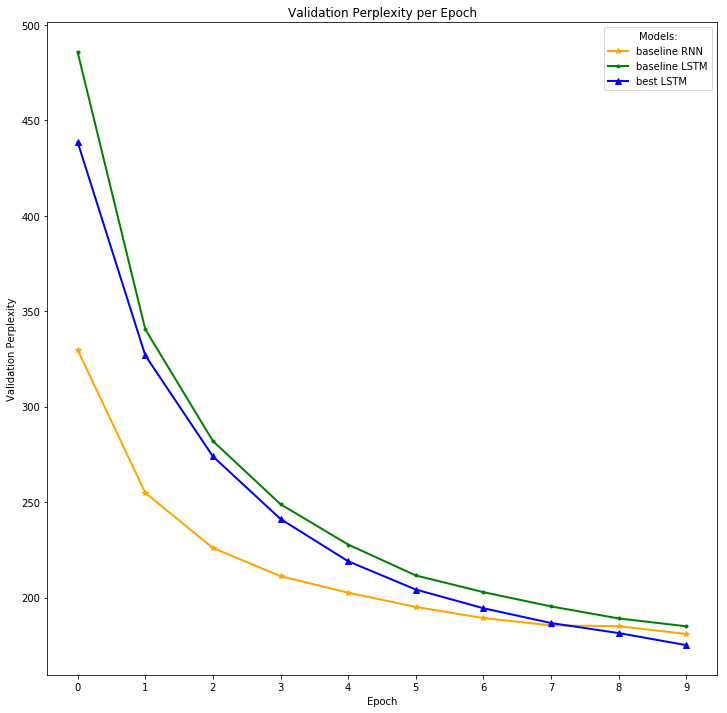

In [29]:
rnn_baseline_ppl = pkl.load(open(path+ 'baseline_rnn_losses.p','rb'))
rnn_baseline_ppl = [lstm_perplexity(ppl[1]) for ppl in rnn_baseline_ppl]

lstm_baseline_ppl = pkl.load(open(path+ 'baseline_lstm_losses.p','rb'))
lstm_baseline_ppl = [lstm_perplexity(ppl[1]) for ppl in lstm_baseline_ppl]

best_lstm_ppl = pkl.load(open(path+ 'Grid Search/emb_dim=128_dropout=0.1.p','rb'))
best_lstm_ppl = [lstm_perplexity(ppl[1]) for ppl in best_lstm_ppl]

plt.figure(figsize=(12,12))
plt.plot([i for i in range(len(rnn_baseline_ppl))], rnn_baseline_ppl, marker='*', color='orange', linewidth=2, label = 'baseline RNN')
plt.plot([i for i in range(len(lstm_baseline_ppl))], lstm_baseline_ppl, marker='.',color='green', linewidth=2, label = 'baseline LSTM')
plt.plot([i for i in range(len(best_lstm_ppl))], best_lstm_ppl, marker='^',color='blue', linewidth=2, label = 'best LSTM')
plt.xticks([i for i in range(10)])
plt.title('Validation Perplexity per Epoch')
plt.ylabel('Validation Perplexity')
plt.xlabel('Epoch')
plt.legend(title='Models:')
plt.show()

#### Performance Variation Based on Hyperparameter Values

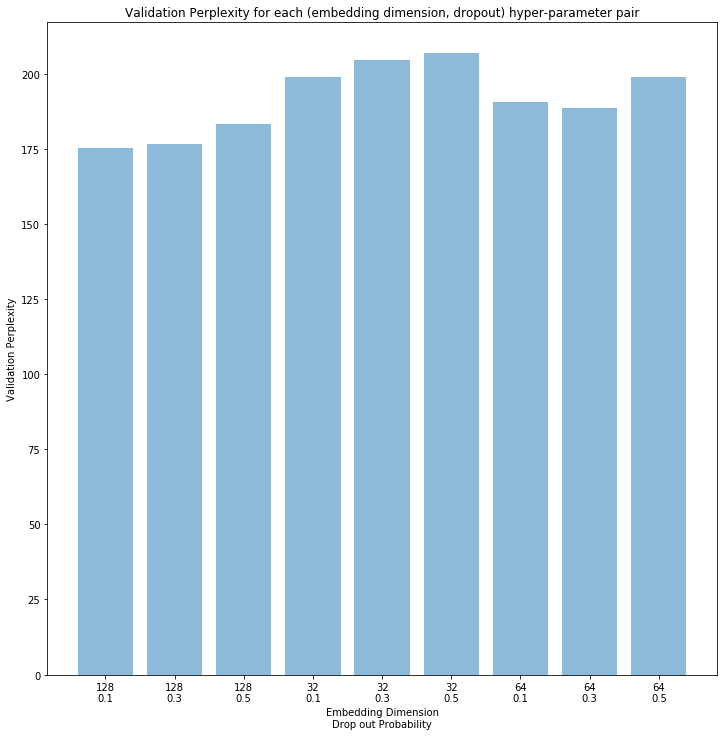

In [7]:
models_dir = [file for file in os.listdir(path+'Grid Search/') if file.endswith('.p')]
models_dir.sort()
perplexities = []
names = []
%matplotlib inline
for file in models_dir:
    ppl_file = pkl.load(open(path+'Grid Search/'+file,'rb'))
    perplexities.append(lstm_perplexity(ppl_file[-1][1]))
    emb_d = re.search(r'(?<=\=)\d+', file).group(0)
    drop_out = re.search(r'(?<=\=)\d\.\d', file).group(0)
    names.append(emb_d + '\n'+ drop_out)

x_pos = range(len(perplexities))
plt.figure(figsize=(12,12))
plt.bar(x_pos, perplexities, align='center', alpha=0.5)
plt.xticks(x_pos, names)
plt.ylabel('Validation Perplexity')
plt.xlabel('Embedding Dimension\nDrop out Probability')
plt.title('Validation Perplexity for each (embedding dimension, dropout) hyper-parameter pair')
plt.show()

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


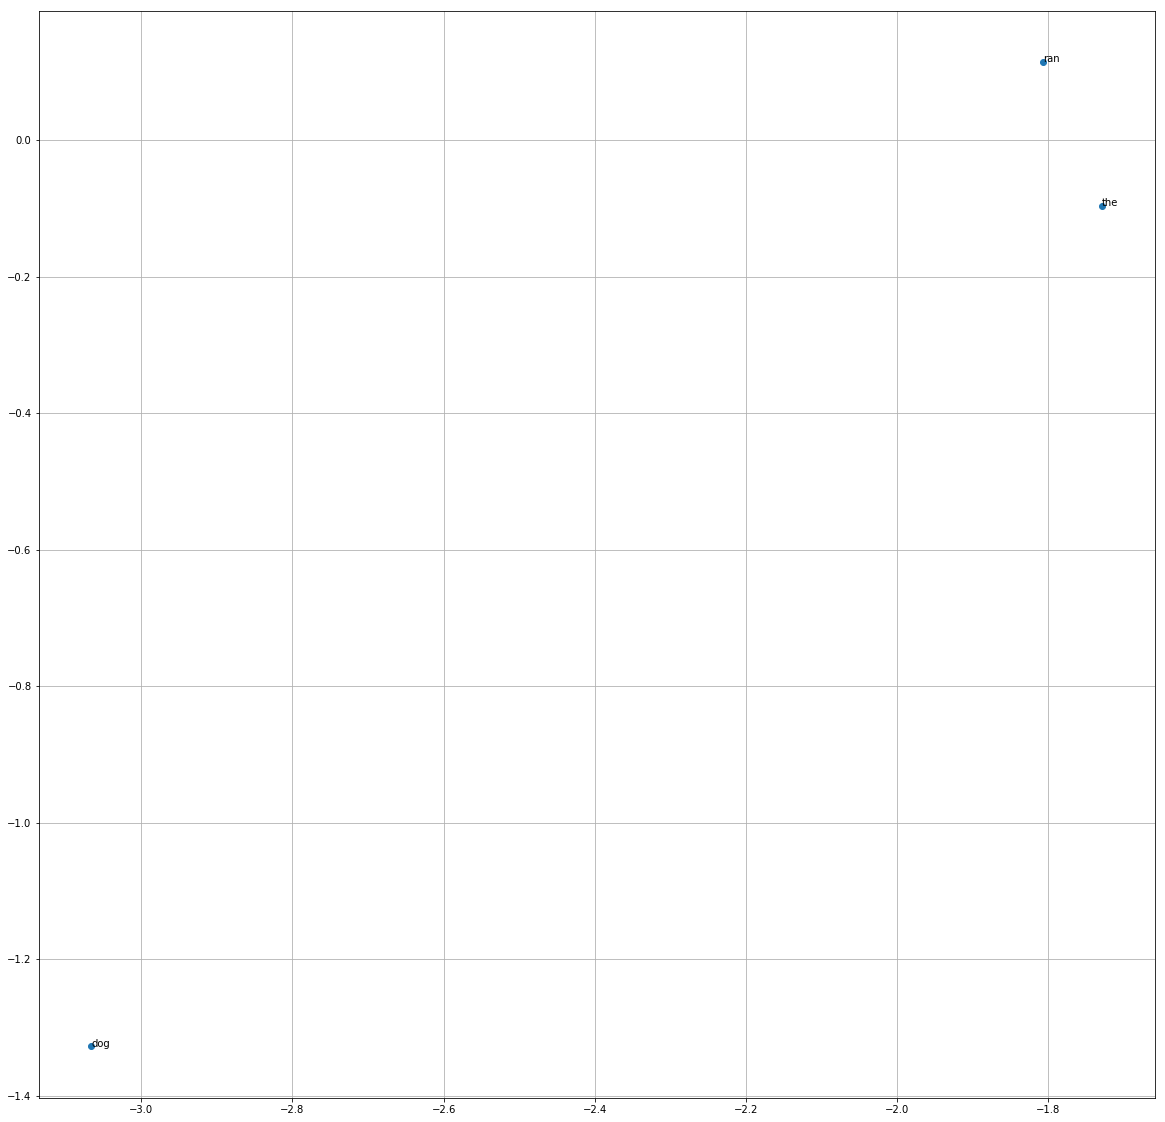

In [0]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

#### II.2.2 Embedding Layer

#### II.2.3 Projection Layer

### II.3 Scoring

In [88]:
import copy

def score_seq(model, seq):
    pass
    
def get_prob(loader):
    
    options = {
                'num_embeddings': len(wiki_dict),
                'embedding_dim': 128,
                'padding_idx': wiki_dict.get_id('<pad>'),
                'input_size': 128,
                'hidden_size': 128,
                'num_layers': 2,
                'rnn_dropout': 0.1,
            }
    model = LSTMModel(options).to(current_device)
    best_model_path = path + "Grid Search/emb_dim=128_dropout=0.1.pt"
    model.load_state_dict(torch.load(best_model_path,  map_location=torch.device(current_device)))
    model.eval()
    lstm_criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))
    

    score_seq_pair_list = []    
  
    valid_losses = []
    with torch.no_grad():
        for i, (inp, target) in enumerate(loader):

          dev_inp = copy.deepcopy(inp).to(current_device) 
          dev_target = copy.deepcopy(target).to(current_device)
          
          logits = model(dev_inp)
          log_prob = lstm_criterion(logits.view(-1, logits.size(-1)), dev_target.view(-1))
    
          score_seq_pair_list.append( (log_prob,  inp[0, :]) )
           
    return score_seq_pair_list
        
def get_worst_best_10(loader):
  
    score_seq_pair_list = get_prob(loader)
    score_seq_pair_list.sort(key=lambda x: x[0]) # sort by first value
    
    worst = [s[1] for s in score_seq_pair_list[:10]]
    best = [s[1] for s in score_seq_pair_list[-10:]]
    
    return worst, best

  

            

def print_best_worst_10(loader, dictionary):
  
    worst_token, best_token = get_worst_best_10(loader)

    
    worst = [dictionary.decode_idx_seq(s) for s in worst_token]
    best = [dictionary.decode_idx_seq(s) for s in best_token]
    
    
    print("Worst 10:")
    for i, s in enumerate(worst):
        print("#" + str(i) + ":")
        print(s)
  
    
    print("Best 10:")
    for i, s in enumerate(best):
        print("#" + str(i) + ":")
        print(s)

#### II.3.2 Highest and Lowest scoring sequences

In [89]:
wiki_datasets_1, wiki_loaders_1 = build_ngram_loader(wiki_all, wiki_dict, 4, 1) #Batch size = 1
print_best_worst_10(wiki_loaders_1["valid"], wiki_dict)              


100%|██████████| 9708/9708 [00:00<00:00, 114150.24it/s]


Worst 10:
#0:
['<bos>', '<bos>', '<bos>', 'they', 'include', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'of', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'of', 'unk', 'unk', 'of', 'unk', 'unk', 'unk', 'unk', 'unk', 'the', 'horn', 'unk', 'unk', 'and', 'unk', 'unk']
#1:
['<bos>', '<bos>', '<bos>', 'unk', 'in', 'the', 'second', 'half', 'of', 'the', '7th', 'century', '\n']
#2:
['<bos>', '<bos>', '<bos>', ' ', 'post', '@-@', 'war', 'period', '\n']
#3:
['<bos>', '<bos>', '<bos>', 'she', 'has', 'also', 'been', 'cast', 'in', 'the', 'film', 'unk', '\n']
#4:
['<bos>', '<bos>', '<bos>', ' ', 'unk', 'from', 'the', 'stage', '\n']
#5:
['<bos>', '<bos>', '<bos>', ' ', 'early', 'life', 'and', 'education', '\n']
#6:
['<bos>', '<bos>', '<bos>', 'it', 'originally', 'aired', 'on', 'unk', 'in', 'the', 'united', 'states', 'on', 'september', '21', '2001', '\n']
#7:
['<bos>', '<bos>', '<bos>', ' ', 'post', '@-@', 'war', 'career', '\n']
#8:
['<bos>', '<bos>', '<bos

#### II.3.3 Modified sequences

### II.4 Sampling

## Loading best trained model-- embedding dimension: 128, dropout: 0.1

Below is included simply for initialization

In [14]:
stock_hidden_size = 128
stock_embedding_size = 128
stock_rnn_dropout = 0.1
stock_num_layers = 2

stock_options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': stock_embedding_size,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': stock_embedding_size,
        'hidden_size': stock_hidden_size,
        'num_layers': stock_num_layers,
        'rnn_dropout': stock_rnn_dropout,
    }

In [15]:
best_model_path = path+'Grid Search/emb_dim=128_dropout=0.1.pt'
best_lstm = LSTMModel(stock_options).to(current_device)
if current_device == 'cpu':
    model_checkpoint = torch.load(best_model_path, map_location=torch.device(current_device))
else:
    model_checkpoint = torch.load(best_model_path)

best_lstm.load_state_dict(model_checkpoint)
best_lstm.eval()

LSTMModel(
  (lookup): Embedding(28792, 128, padding_idx=2)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=28792, bias=True)
)

# Notes on `generate_sentences()`
Due to the fact that we built our RNN and LSTM models on n-grams, specifically 4-grams, it was not possible to simply pass a single token to our pretrained model at each iteration of the innermost `while`-loop. When passing a single word/token, what is returned is a high likelihood of `<bos>` following our currently fed word rather than continuing through the sequence/sentence. Remember that this is due to the fact that we padded the start of our n-grams with `<bos>` a total of $(n-1)$ times. Furthermore, this is a result of how we defined our **target** classes--see the class `TensoredDataset` for more info. To be more specific, our inputs and our targets were **both** sequences.

So instead of passing individual tokens, we proceed by appending each generated word to a tensor named `sentence`. The growing tensor is fed back into our model _until_ the next word that is generated is `<eos>`, at which point we consider the sentence generated.

In [18]:
import torch.nn.functional as F
out = model.lookup(seq)
next = model.lstm(out)
last = model.projection(next)
def generate_sentences(model, vocabulary, total_sentences=1000):
    all_sentences = []
    with tqdm(total=total_sentences) as pbar:
        while len(all_sentences) < total_sentences:
            first_word_idx = [vocabulary.get_id('<bos>')]
            first_word_tensor = torch.LongTensor([first_word_idx])
            sentence = torch.LongTensor([first_word_idx])
            first_elem_passed = False
            eos = False
            while not eos:
                seq_out = model(sentence)
                word_prob = F.softmax(seq_out, dim = 2).squeeze()
                if len(word_prob.size()) > 1: 
                    word_prob = word_prob[word_prob.size()[0] - 1 ]

                word = torch.multinomial(word_prob, num_samples = 1)
                word = int(word.data[-1:])
                if word == vocabulary.get_id('<eos>'):
                    eos = True
                word = torch.tensor([word], dtype = torch.long)
                sentence = torch.cat((sentence.squeeze(0), word))    
                sentence = sentence.expand(1,sentence.size()[0])
            all_sentences.append(vocabulary.decode_idx_seq([int(i) for i in sentence.squeeze()]))
            pbar.update(1)
    return all_sentences
            

In [19]:
sentences_1000 = generate_sentences(best_lstm, wiki_dict)

100%|██████████| 1000/1000 [03:21<00:00,  4.09it/s]


In [25]:
pkl.dump(sentences_1000, open('one_thousand_sentences.p','wb'))

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

In [31]:
sentences_1000 = pkl.load(open(path+'one_thousand_sentences.p','rb'))

In [57]:
random_val_idx = list(np.random.choice(len(wiki_val), 1000, replace=False))
random_val_1000 = [wiki_val[idx] for idx in random_val_idx]

In [58]:
def get_set_size(sequences):
    full_set = set()
    for tokens in sequences:
        full_set = full_set.union(set(tokens))
    
    return len(full_set)

In [59]:
generated_num_uniq = get_set_size(sentences_1000)
generated_num_uniq

5933

In [60]:
val_num_uniq = get_set_size(random_val_1000)
val_num_uniq

4548

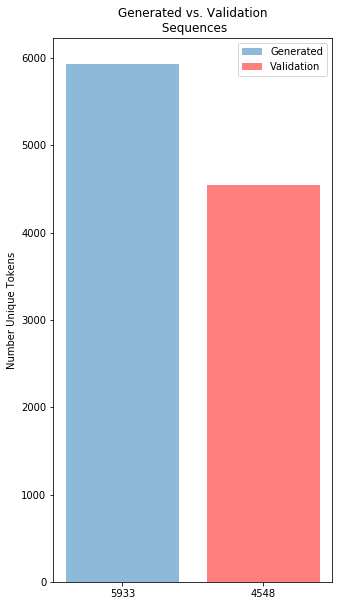

In [61]:

%matplotlib inline
plt.figure(figsize=(5,10))
plt.bar([0], [generated_num_uniq], align='center', alpha=0.5, label = 'Generated')
plt.bar([1], [val_num_uniq], align='center', alpha=0.5, color = 'red', label = 'Validation')
plt.ylabel('Number Unique Tokens')
plt.title('Generated vs. Validation\n Sequences')
plt.xticks([0,1], [str(generated_num_uniq), str(val_num_uniq)])

plt.legend()
plt.show()

In [62]:
def get_lengths(sequences):
    lengths = []
    for seq in sequences:
        lengths.append(len(seq))
    return lengths

In [63]:
generated_lens = get_lengths(sentences_1000)
validation_lens = get_lengths(random_val_1000)

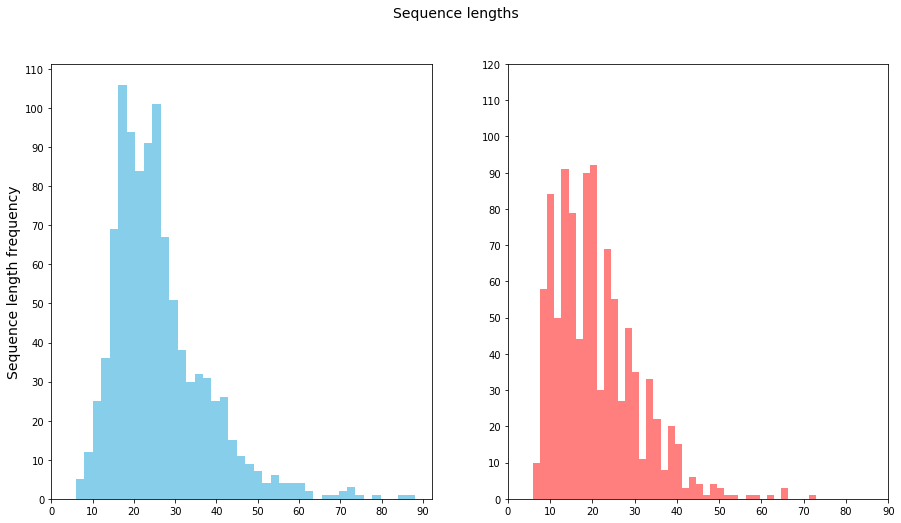

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Sequence lengths', fontsize=14)
axs[0].hist(generated_lens, bins=40, color = 'skyblue')
axs[0].set_ylabel('Sequence length frequency', fontsize=14)
axs[0].set_xticks([i*10 for i in range(10)])
axs[0].set_yticks([i*10 for i in range(12)])
axs[1].hist(validation_lens, bins=40, alpha = 0.5, color = 'red')
axs[1].set_xticks([i*10 for i in range(10)])
axs[1].set_yticks([i*10 for i in range(13)])

plt.show()

#### II.4.4 Example Samples

As we observe below, the generated sequences are _clearly_ model-generated as opposed to human-made. Regarding the topic, we see that the sentences stay on topic for a certain succession of words. In this case, due to the fact that we trained a 4-gram, it appears that it's around a sequence of 4 words that a complete thought is expressed/ a topic is maintained. After this point, the sequence appears to change topic. As a result, the generated sequences are not grammatically correct.

For example, taking the latter half of the 3rd generated sentence below, we see the mention of `on 25 april 1880`, which describes a date/event but follow this there is a mention of an entirely different date. This hints that when the model sees a number, it might assign relativily higher probabilities of the next words being related to 'date' topic. 

In [79]:
np.random.seed(111)
for seq in np.random.choice(len(sentences_1000), 3, replace = False):
    print(' '.join(sentences_1000[seq]))
    print('\n')
    print('\n')

<bos> <bos> <bos> around this time in 1989 power and gaining no home conditions wheeler 's gather sometimes brought a new straight u @-@ issue 
 <eos>




<bos> <bos> <bos> the caa 's corn deals an extratropical album bolívar was nominated as the ninth years sound benefits and the unk building is operating ramps project in their network prefect and in accepting 60 county north of the eastern pacific stream <eos>




<bos> <bos> <bos> it was shortly a game at the register of its points on 25 april 1880 on september 9 <eos>




